In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 27 16:05:08 2025

@author: david.osuna

"""

"""
------------------------------------------------------------------------------

CONTEXT:

    Here we are going to write a draft code for running micromagnetic 
    simulations with UBERMAG (OOMMF).
    
GOAL:
    
    The idea is to obtain results (TRANSMISSION and REFLECTION) OF SWs in a 
    standard geometry (FM strip with a inhomogeneous stripe) adn record them
    in an OUPUT table.
    The independent variables (i.e. material parameters) are:
        
        Saturation Magnetisation    (Ms)
        Exchange Stiffness          (A_ex)
        Uniaxial Anisotropy         (uv)
        Gilbert Damping             (alpha)
        
    The code CALLS secondary functions
    
    
    
 ** RUNNING NOTES BELOW ** 
 
 (27-02-2025)
 At this point, only a draft is written about a standard process
 of applying PCA and clustering to a fake dataset. SIMULATIONS ARE NOT DONE YET
 
 Also, I could refine PCA & clustering by adding interaction terms, or 
 use non-linear methods (e.g., t-SNE, UMAP) to detect complex patterns
 
 ()
 


"""


"""
------------------------------------------------------------------------------
-----------------------     FUNCTIONS     ------------------------------------
------------------------------------------------------------------------------
"""



def rgb_to_hex(rgb_tuple):
    """
    Convert a normalized RGB tuple (values between 0.0 and 1.0) to a hexadecimal color code.

    Parameters:
        rgb_tuple (tuple): A tuple with three floats representing RGB values (e.g., (1.0, 0.0, 0.0)).

    Returns:
        str: The hexadecimal color code as a string (e.g., "#ff0000").
    """
    # Ensure RGB values are within the valid range
    if not all(0.0 <= value <= 1.0 for value in rgb_tuple):
        raise ValueError("RGB values must be between 0.0 and 1.0.")
    
    # Scale the normalized values to the 0-255 range and convert to integers
    scaled_rgb = tuple(int(value * 255) for value in rgb_tuple)
    
    # Convert to hexadecimal format
    return '#{:02x}{:02x}{:02x}'.format(*scaled_rgb)




# -------------------            DEFINICIÓN DE FUNCIONES               -----------------

def set_param_in_abs(levels_, param_, value1_, value2_):
    for i in range(1, levels_ + 1):
        if i < 0.5*levels_+1:
            param_[f"region_{i+2}"] = value1_
        else:
            param_[f"region_{i+2}"] = value2_
    return param_


def set_alpha_in_abs(levels_, param_, value1_, value2_, alpha_abs):
    for i in range(1, levels_ + 1):
        if i < 0.5*levels_+1:
            param_[f"region_{i+2}"] = (i-1)*(value1_ - alpha_abs) / (0.5*levels_ - 1) + alpha_abs
        else:
            param_[f"region_{i+2}"] = (i-1)*(alpha_abs - value2_) / (0.5*levels_) + value2_
    return None
 

def set_linear_param_in_regions(rango, param_, value1_, value2_):
    a = rango[0]
    b = rango[-1]
    
    if (type(value1_) is not tuple):
        if len(rango) == 1:  # Handle single element case
            param_[f"region_{a}"] = value1_
        elif b != a or value1_ != value2_:
            increasing = [(i - a) * (value2_ - value1_) / (b - a) + value1_ for i in rango]
            for i, value in zip(rango, increasing):
                param_[f"region_{i}"] = value
        else:  # Handle case when `b == a` and `value1_ == value2_`
            for i in rango:
                param_[f"region_{i}"] = value1_
        
    else:
        for i in rango:
            param_[f"region_{i}"] = value1_
    
    return None


# def MAKE_GRID()


def time_average_up_to_t0(comp, x0, t_i, t_f):
    """
    Compute the time average of the signal recorded at m_field along a line up to t0.
    
    Args:
    drive: A function or array representing the signal from which m_field is derived.
    t0: The time up to which the averaging is done (index of the last time step to consider).
    line: The line object (e.g., `lineOUT`) along which the average is computed.
    W: Width parameter used to define the line geometry.
    ABS_x: An offset used to modify the position along the line.
    d: A depth or dimension used in the line's geometry.
    
    Returns:
    avg_signal: Time-averaged signal along the line up to t0.
    """
    
    # Initialize a list to accumulate signal values
    signal_accumulated = []
   

    # Loop through times from 1 to t0 (assuming 'drive' provides signals for each time step)
    for t in range(t_i, t_f + 1):  # Time step loop from 1 to t0
        # Compute m_field for the current time step
        m_field = drive[t] - drive[1]

                
        # COMPROBAMOS EN EL EJE X
        lineOUT = m_field.line(p1=(0, 0, round(d / 2)), p2=(L, 0, round(d / 2)), n=1000)
     
        # Extract the signal data at the line (Assumed method to get the line data)
        signal_at_t = lineOUT.data[comp]  # Modify this according to the actual method to get data from line
        
        # Append the signal data for the current time
        signal_accumulated.append((signal_at_t))        

    
    # Convert list of accumulated signals to a numpy array
    avg_signal = np.mean(signal_accumulated, axis=0)

    # The y_position (e.g., lineOUT.data['r']) should be defined already
    y_position = lineOUT.data['r']  # Assuming this exists
    
    # Slice the signal (this is the part you're interested in)
    lista = avg_signal[round(len(avg_signal)*0.5):len(avg_signal)]
    
    # Find the maximum index and value within the sliced signal
    max_index = np.argmax(lista)
    max_value = lista[max_index]
    
    # Print the correct position of the maximum in the original signal (accounting for the slice)
    original_max_position = max_index + round(len(avg_signal)*0.5)
    print(f"Maximum position (in original signal): {y_position[original_max_position]*1e6}")
    print(f"Maximum value: {max_value}")

    #y_position = np.linspace(-W/2+ABS_x, W/2-ABS_x, len(y_position))

    '''
    # Plot the signal
    plt.plot(y_position, avg_signal, label="Signal")
    
    # Plot the maximum value as a red circle
    plt.scatter(y_position[original_max_position], max_value, color='red', label="Maximum Value")
    
    # Add titles and labels
    plt.title("Signal with Maximum Value")
    plt.xlabel("Position (y)")
    plt.ylabel("Signal Amplitude")
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()
    '''
    return avg_signal


In [2]:
import micromagneticmodel as mm
import discretisedfield as df
import oommfc as mc
import matplotlib.pyplot as plt
import micromagneticdata as mmd
#import holoviews as hv
import numpy as np
import pandas as pd
#import pyvista as pv
import os
# import imageio
import math
import random
from PIL import Image
from itertools import product
from scipy.fftpack import fft
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import clear_output
import time
import shutil
import itertools
#hv.extension('bokeh')
#hv.output(widget_location="bottom")

from pyDOE import lhs


"---------------------    MAKING THE GRID    -----------------------------"

W = 20.000 µm
reg_w =  0.6
sr1_x =  8.000000000000002
sr2_x =  11.000000000000002
levels_MTM =  17
columns_MTM =  1
reg_w =  0.6
reg_wx =  2.0
x_1 =  25.0
x_2 =  27.000000000000004
L =  50.0
Exchange length (nm) =  20.852334892728596

"---------------------    Color gradients    -----------------------------"

17
17

"---------------------    INITIAL SUBREGIONS    --------------------------"

5e-06
2
2

"---------------------    MTM SUBREGIONS    ------------------------------"

19
19

"---------------------    PML SUBREGIONS    ------------------------------"

119
119

"---------------------    MESHING...    ----------------------------------"


"---------------------     ... DONE!    ----------------------------------"



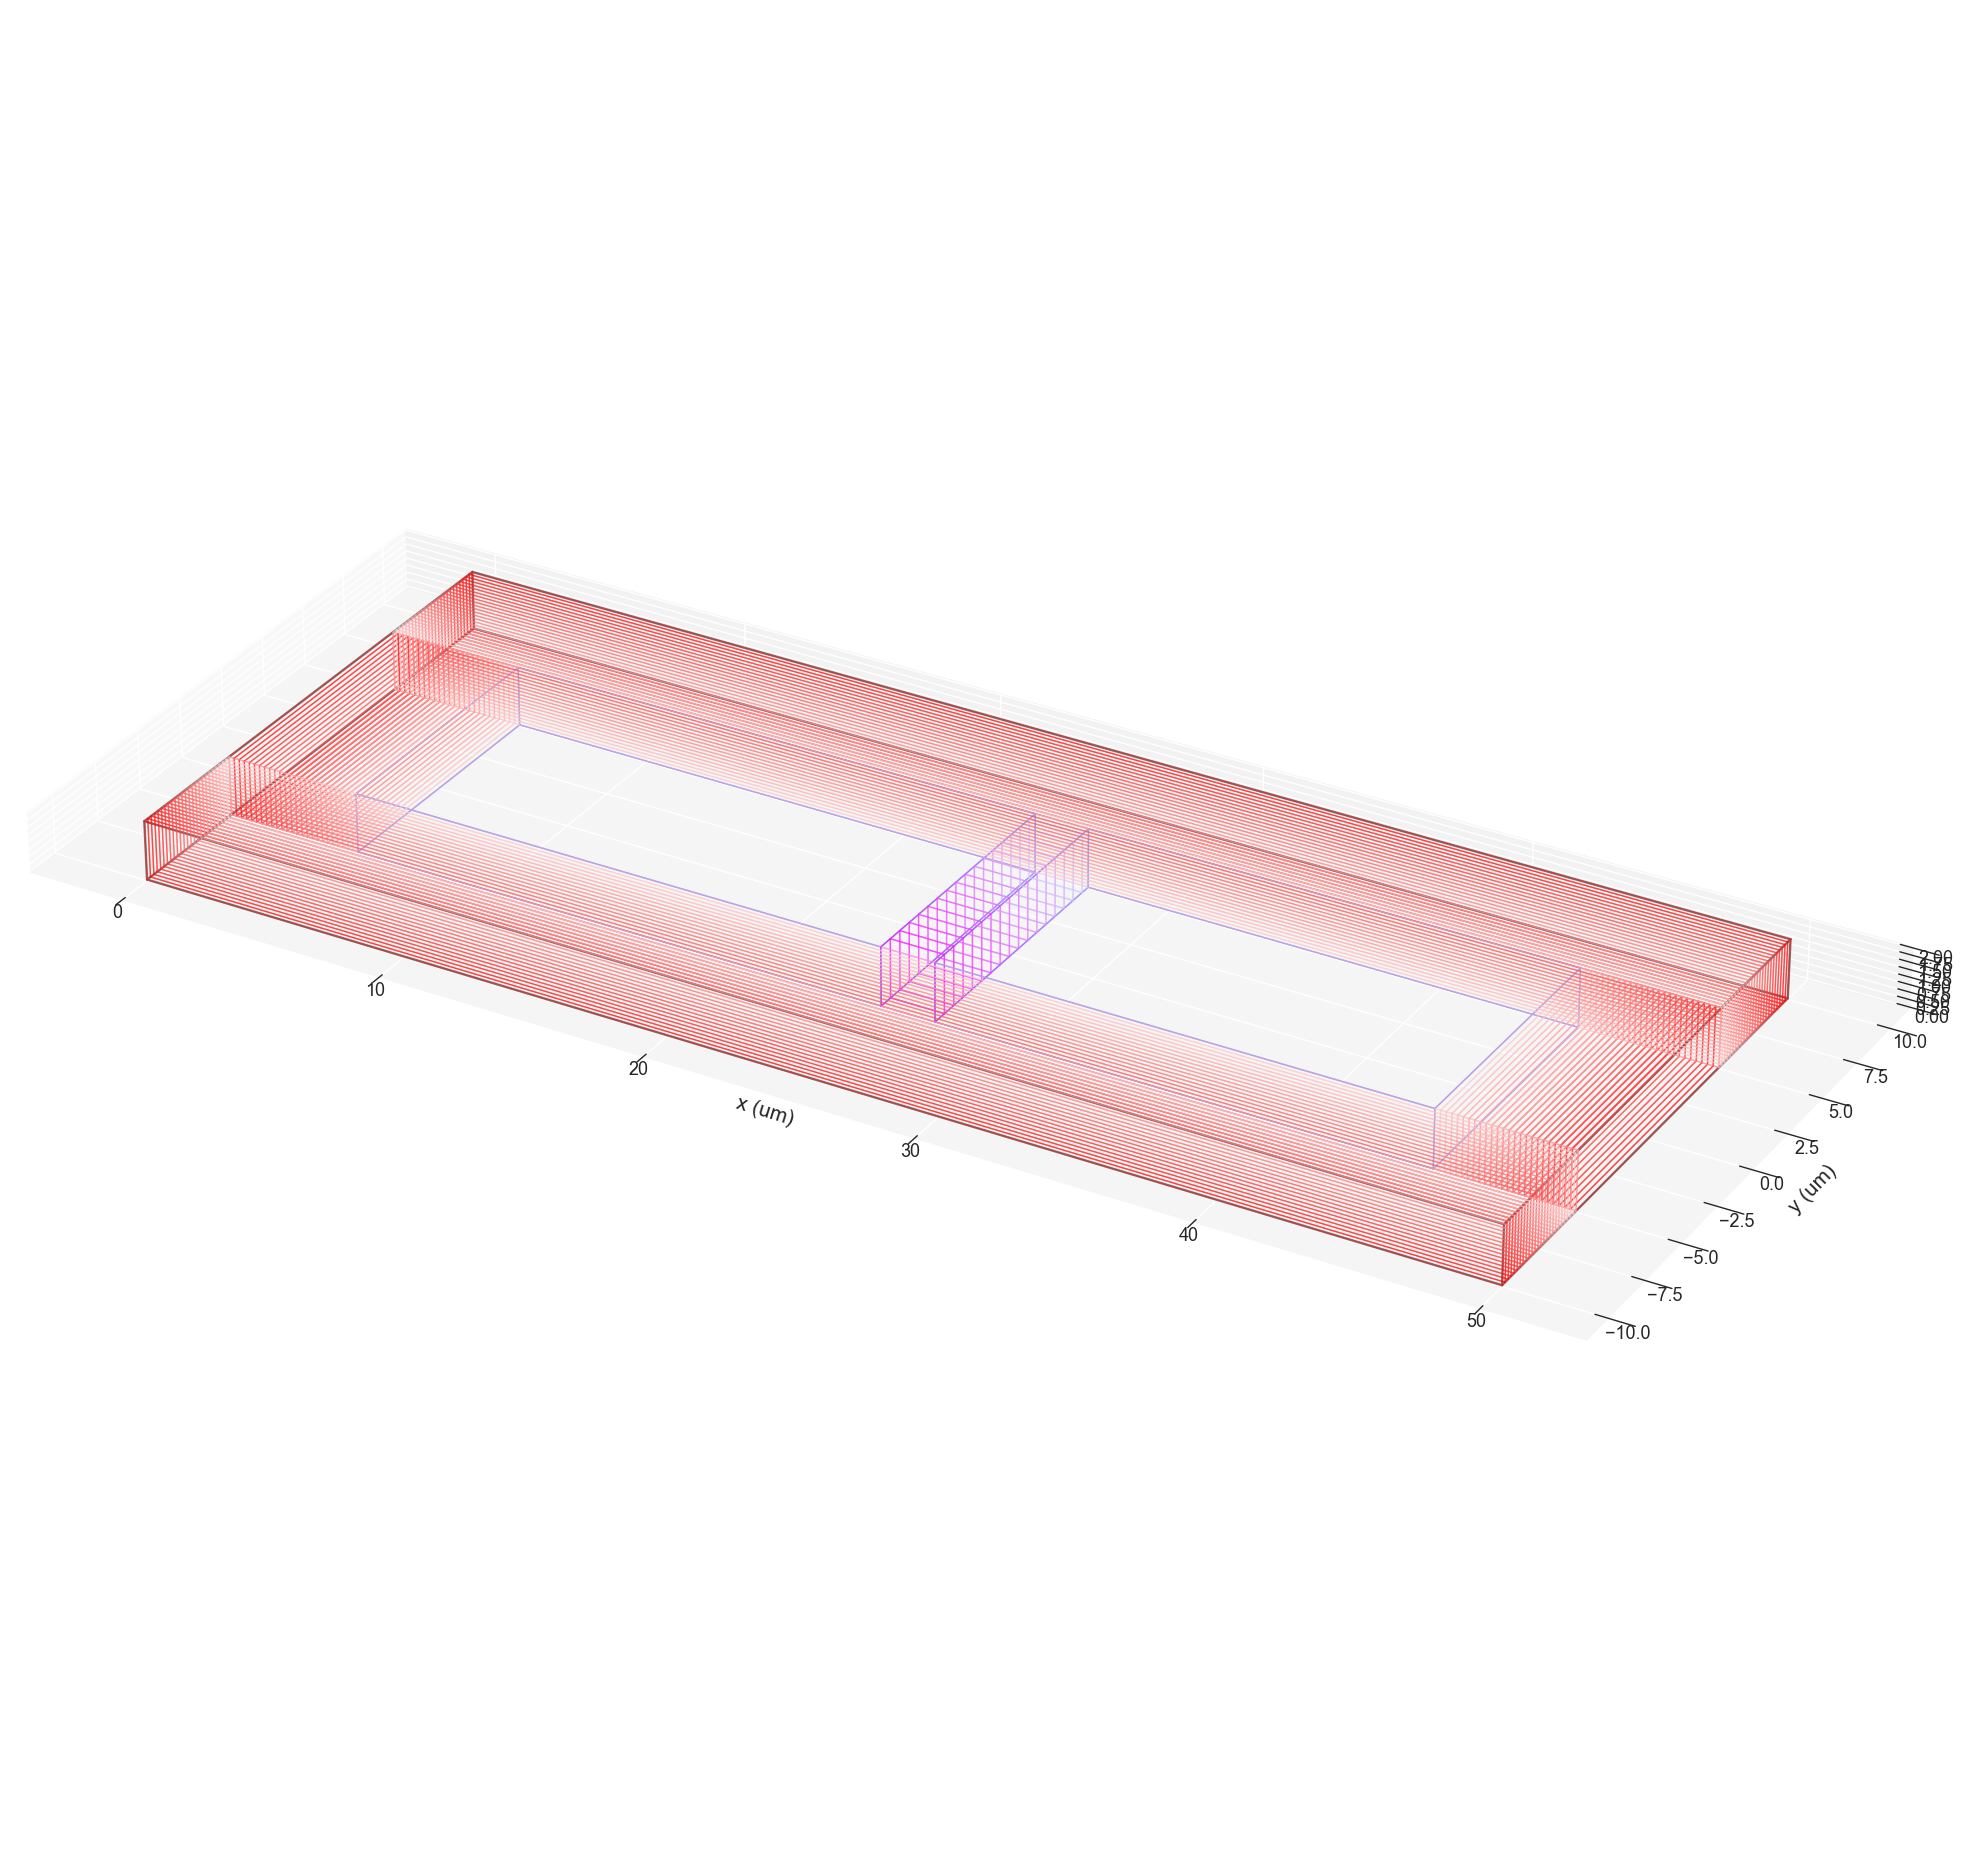

In [3]:

"""
------------------------------------------------------------------------------
-----------------------        MAIN       ------------------------------------
------------------------------------------------------------------------------
"""


"""

---------------------    MAKING THE GRID    ----------------------------------

"""

print('''
"---------------------    MAKING THE GRID    -----------------------------"
''')


# Cell sizes

dx = 0.2e-6   # 10e-9
dy = 0.2e-6   # 10e-9
dz = 1e-6   # 5e-9


# Extensión de los absorbedores
ABS_x = 5e-6  # 20e-9

L = 40e-6 + 2*ABS_x  # 2*x_2

# Regiones en el material III (cheese) y en el diffraction grating:

levels_MTM = 17   # 15

# Hallamos la W total de la estructura y con ello, la anchura de las regiones en el MTM:



W = 50*dy + 2*ABS_x
print(f'W = {W * 1e6:.3f} µm')

if not np.isclose(W / dy, round(W / dy), atol=1e-9):  # Allow small tolerance for floating-point errors
    raise ValueError("W cannot be discretized into cell sizes of width dy")

# Hallamos el ancho de cada fila en el MTM:
reg_w = np.floor((W-2*ABS_x)/levels_MTM / dy) * dy
reg_w = (W-2*ABS_x)/levels_MTM
reg_w = round(reg_w / dy) * dy
print(f'reg_w = ', reg_w*1e6)

if not np.isclose(reg_w / dy, round(reg_w / dy), atol=1e-9):
    raise ValueError("Width of rows cannot be discretized into cell sizes of width dy")

reg_w_last = (W - 2 * ABS_x) - (levels_MTM - 1) * reg_w

# Source position

sr1_x = ABS_x + 3e-6    #  ABS_x + cell[0]
sr2_x = sr1_x + 3e-6  # 3*cellsize_x (width)

sr1_y = -W/2 + ABS_x  # -3*cell[0]
sr2_y = W/2 - ABS_x   # 3*cell[0]

print(f'sr1_x = ', sr1_x*1e6)
print(f'sr2_x = ', sr2_x*1e6)



# Regiones en el material III (aligned cheese)

total_width_lens = 10*dx # 4.4e-6

columns_MTM = 1

reg_wx = round(total_width_lens / levels_MTM / dx) * dx
reg_wx = round(total_width_lens / columns_MTM / dx) * dx

# columns_MTM = int(np.floor(total_width_lens / reg_wx))

# columns_MTM = 20+2   #  2*levels_MTM 60,  130 + 4 + 130 (= Lg + delta + Lg) = 264 y entre 2 para que cuadre con REG_W = 2dx
                   # luego 132 = 66 + 2 + 64
# columns_MTM = int(np.floor(50e-6 / (reg_w)))
print(f'levels_MTM = ', levels_MTM)
print(f'columns_MTM = ', columns_MTM)
width = dx

actual_width_x = columns_MTM * reg_wx

x_1 = L/2  # x_dif + 5e-6  

x_2 = x_1 + actual_width_x

print(f'reg_w = ', reg_w*1e6)
print(f'reg_wx = ', reg_wx*1e6)
print(f'x_1 = ', x_1*1e6)
print(f'x_2 = ', x_2*1e6)




# Regions parameters --- We can define SUBREGIONS as well
d = 2*dz
#W = 500e-6



print(f'L = ', L*1e6)
d_B = d    # grosor de los bloques superiores
p1_0 = (0, -W/2, 0)
p2_0 = (L, W/2, d)

# Micromagnetic parameters

A_0 = 4e-12  # exchange energy constant (J/m)
Ms = 1.21e5 # Saturation Magnetisation (A/m)
gamma0 = 2.135e5   # gyromagnetic ratio (m/As)
alpha_d = 0.01  # Gilbert Damping   0.0005
alpha_high = 1.0  # Fictitious damping for rapid convergence
K0 = 0    # Uniaxial anisotropy constant
u0 = (1, 0 ,0) # Easy axis
angle_u = 90. # in DEGREES    --->   0. = BVSW, (uv in x),, 90. = FVSW, uv in z
uv = (np.cos(angle_u * np.pi / 180.), 0, np.sin(angle_u * np.pi / 180.) ) # PMA (perpendicular magnetic anisotropy)
nu0 = 4*math.pi*1e-7 #Magnetic permeability in vacumm

Hbias = 176.5e3   # ANTES 176.5e3 = 804 kA/m
f0 = 0.5e9; # 2 GHz

lx = math.sqrt(2*A_0/nu0)/Ms # Exchange length
print(f'Exchange length (nm) = ', lx*1e9)

region = df.Region(p1=p1_0, p2=p2_0)   # The 'region' object is created





print('''
"---------------------    Color gradients    -----------------------------"
''')

start_color_2 = np.array([1.0, 0.0, 1.0])  # Pure blue (RGB)
end_color_2 = np.array([0.8, 0.8, 1.0])    # Light blue (RGB)
#end_color_2 = start_color_2    # Light blue (RGB)
gradient_blue = [tuple((1 - t) * start_color_2 + t * end_color_2) for t in np.linspace(0, 1, levels_MTM)]
gradient_blue2 = [tuple((1 - t) * start_color_2 + t * end_color_2) for t in np.linspace(0, 1, levels_MTM)]

gradient_hex_MTM = [rgb_to_hex(color) for color in gradient_blue]
gradient_hex_dif = [rgb_to_hex(color) for color in gradient_blue2]
print(len(gradient_hex_MTM))
print(len(gradient_hex_dif))




# En los absorbedores

# abs_layers = 100  # 10 regions-absorbers at both ends

abs_w = dx
abs_layers = round(ABS_x / abs_w)

color_list=['b', 'b']  # first and second region is blue

start_color_1 = np.array([1.0, 0.0, 0.0])  # Pure red (RGB)
end_color_1 = np.array([1.0, 0.8, 0.8])    # Light red (RGB)
#end_color_1 = start_color_1    # Light red (RGB)
gradient_red = [tuple((1 - t) * start_color_1 + t * end_color_1) for t in np.linspace(0, 1, abs_layers)]
    
gradient_hex_abs = [rgb_to_hex(color) for color in gradient_red]



print('''
"---------------------    INITIAL SUBREGIONS    --------------------------"
''')
# We add the first original subregions (N)
# NOTE THAT THERE WILL BE AN OFFSET INTEGER N FOR DEFINING THE SUBSEQUENT SUBREGIONS (N+1, ... , M)!!

subregions = {
    "region_1": df.Region(p1=(ABS_x, -W/2+ABS_x, 0), p2=(x_1, W/2-ABS_x, d)),
    "region_2": df.Region(p1=(x_2, -W/2+ABS_x, 0), p2=(L-ABS_x, W/2-ABS_x, d))
}
ros_i = 2

print(ABS_x)
print(len(subregions))
print(len(color_list))



print('''
"---------------------    MTM SUBREGIONS    ------------------------------"
''')
# We add the aligned cheese subregions (N)
# NOTE THAT THERE WILL BE AN OFFSET INTEGER N FOR DEFINING THE SUBSEQUENT SUBREGIONS (N+1, ... , M)!!
'''
for nc in range(1, columns_MTM + 1):

    for i in range(1, levels_MTM + 1):
        #subregions[f"region_{1+i}"] = df.Region(p1=(border, -W/2+ABS_x+reg_w*(i-1), 0), p2=(L-ABS_x, -W/2+ABS_x+reg_w*i, d))
        current_reg_w = reg_w_last if i==levels_MTM else reg_w
            
        subregions[f"region_{ros_i+i+(nc-1)*levels_MTM}"] = df.Region(
            p1=(x_1+reg_wx*(nc-1), -W/2+ABS_x+current_reg_w*(i-1), 0), 
            p2=(x_1+reg_wx*nc, -W/2+ABS_x+current_reg_w*i, d))
    color_list.extend(gradient_hex_MTM)

ros_c = ros_i + columns_MTM*levels_MTM
'''



for nc in range(1, columns_MTM + 1):

    for i in range(1, levels_MTM + 1):
        if i < levels_MTM:
            y_start = -W/2 + ABS_x + reg_w * (i - 1)
            y_end = -W/2 + ABS_x + reg_w * i
        else:  # Last row uses reg_w_last
            y_start = -W/2 + ABS_x + reg_w * (i - 1)
            y_end = -W/2 + ABS_x + reg_w * (levels_MTM - 1) + reg_w_last

        subregions[f"region_{ros_i+i+(nc-1)*levels_MTM}"] = df.Region(
            p1=(x_1 + reg_wx * (nc - 1), y_start, 0),
            p2=(x_1 + reg_wx * nc, y_end, d)
        )

    color_list.extend(gradient_hex_MTM)

ros_c = ros_i + columns_MTM * levels_MTM




print(len(subregions))
print(len(color_list))



print('''
"---------------------    PML SUBREGIONS    ------------------------------"
''')
# We add the PML layers in the x-directions as new subregions (starting at subregion_3),
# from x = 0 upwards, and from x = L downwards.

for i in range(1, 2*abs_layers + 1):
    if i < abs_layers+1:
        subregions[f"region_{ros_c+i}"] = df.Region(p1=(abs_w*(i-1), -W/2+ABS_x, 0), p2=(abs_w*i, W/2-ABS_x, d))
    else:
        subregions[f"region_{ros_c+i}"] = df.Region(p1=(L-abs_w*(i-abs_layers-1), -W/2+ABS_x, 0), p2=(L-abs_w*(i+1-abs_layers-1), W/2-ABS_x, d))
color_list.extend(gradient_hex_abs)
color_list.extend(gradient_hex_abs)

ros_a1 = ros_c + 2*abs_layers

# We add the PML layers in the y-directions as new subregions (starting at subregion_3),
# from y = -W/2 upwards, and from x = W/2 downwards.

for i in range(1, 2*abs_layers+1):
    if i < abs_layers+1:
        subregions[f"region_{ros_a1+i}"] = df.Region(p1=(0, -W/2+abs_w*(i-1), 0), p2=(L, -W/2+abs_w*i, d))   # border, not L-ABS_x
    else:
        subregions[f"region_{ros_a1+i}"] = df.Region(p1=(0, W/2-abs_w*(i-abs_layers-1), 0), p2=(L, W/2-abs_w*(i+1-abs_layers-1), d))
color_list.extend(gradient_hex_abs)
color_list.extend(gradient_hex_abs)

print(len(subregions))
print(len(color_list))
#print(subregions)

ros_a2 = ros_a1 + 2*abs_layers

print('''
"---------------------    MESHING...    ----------------------------------"
''')
# ----------------------------------    Meshing    ---------------------------
# Meshing
cell = (dx, dy, dz)
# n = ()   #  number of cells in x, y, z
color_tuple = tuple(color_list)
mesh = df.Mesh(region=region, cell=cell, subregions=subregions, bc='')  # Definition of mesh in defined regions    # bc='xy'  : PBC along x and y, bc=''  : open boundaries
mesh.mpl.subregions(figsize=(24, 24), linewidth=1, linestyle="solid", color=color_list,
                    alpha=0.5,
                    show_region=True
                   )

print('''
"---------------------     ... DONE!    ----------------------------------"
''')


In [4]:

print('''
"-------------   FINAL LISTS WITH NUMBERED SUBREGIONS    -----------------"
''')

#  ---------     Vector de entrada describiendo el número y tipos de regiones:    ----------

#       [1, ..., N]          +       [N+1, ... , M]       +       [M+1, ..., P]
# regiones iniciales (N=2)      regiones en material II       regiones absorbentes

regiones_iniciales = range(1,ros_i+1) 
#regiones_difrac = range(ros_i+1, ros_d+1)
regiones_MTM =       range(ros_i+1, ros_c+1) 
regiones_abs_in_plusx =  range(ros_c+1, ros_c+abs_layers+1)
regiones_abs_in_minusx = range(ros_c+abs_layers+1, ros_c+2*abs_layers+1)
regiones_abs_in_plusy =  range(ros_c+2*abs_layers+1, ros_c+3*abs_layers+1)
regiones_abs_in_minusy = range(ros_c+3*abs_layers+1, ros_c+4*abs_layers+1)
regiones_abs_in_air = range(ros_c+4*abs_layers+1, ros_c+4*abs_layers+1 + 4 + 1)


print((list(regiones_iniciales)))

print((list(regiones_MTM)))
print((list(regiones_abs_in_plusx)))
print((list(regiones_abs_in_minusx)))
print((list(regiones_abs_in_plusy)))
print((list(regiones_abs_in_minusy)))




"-------------   FINAL LISTS WITH NUMBERED SUBREGIONS    -----------------"

[1, 2]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]


In [5]:

# --------------------        NÚMERO DE ITERACIONES       -------------------

It = 10

param = Ms

min_param = 0.75*Ms
max_param = 1.2*Ms

params = np.linspace(min_param, max_param, It)
range_param = params.tolist()


# ......   Parámetros sobre los que iterar: -------
#
#       Ms     A_0     uv     (Hbias)     alpha_d1

# Define parameter ranges
Ms_values = [Ms, 0.7e5, 0.8e5, 0.9e5, 1.0e5, 1.09e5, 1.33e5, 1.4e5, 1.5e5, 1.6e5]   # Example range for parameter 1
A_0_values = [A_0]      # Example range for parameter 2
Ku_values = [K0]          # Example range for parameter 3
alpha_d1_values = [alpha_d, 0.015, 0.02]
angle_u_values = [90., 80., 70., 60., 50., 40., 30., 20., 10., 0.]



#######  CUIDADO AQUÍ, PORQUE AL PONER ALPHA MENOR QUE 0.01 (MI REFERENCIA), ME ESTÁN SALIENDO T > 1 !!

# Define parameter ranges
Ms_values = np.arange(0.2*Ms, 1.0*Ms, 0.1*Ms)  # Example range for parameter 1
#A_0_values = np.arange(0.8*A_0, 1.2*A_0, 0.1*A_0)  # Example range for parameter 1
# Ku_values = np.arange(0.6*K0, 1.3*K0, 0.05*K0)          # Example range for parameter 3
alpha_d1_values = np.arange(alpha_d, 2.1*alpha_d, 0.1*alpha_d)
#angle_u_values = [90., 80., 70., 60., 50., 40., 30., 20., 10., 0.]
angle_theta_values = np.arange(90., 0., -2.0)
angle_phi_values = np.arange(0., 90., 2.0)


print(len(Ms_values))
print(len(A_0_values))
print(len(Ku_values))
print(len(alpha_d1_values))
print(len(angle_theta_values))
print(len(angle_phi_values))


# Generate all combinations (Cartesian product)
all_combinations = list(itertools.product(Ms_values, A_0_values, alpha_d1_values, angle_theta_values, angle_phi_values))
random.shuffle(all_combinations)  # Randomize the order

#--------------  PARAMETER BOUNDS FOR SIMULATIONS USIN LHS  ----------------

# Define bounds for each variable
param_bounds = {
    'Ms':      (0.2 * Ms, 1.0 * Ms),
    'A_0':     (A_0, A_0),         # Set these according to your domain
    'alpha_d': (alpha_d, 2.1 * alpha_d),
    'theta':   (0., 90.),                # θ in [0°, 90°]
    'phi':     (0., 90.)                 # φ in [0°, 90°]
}

n_samples = 1000  # You decide how many simulations to run

# Generate LHS samples
lhs_samples = lhs(len(param_bounds), samples=n_samples)

# Scale to actual parameter ranges
scaled_samples = []
for i, (param, (low, high)) in enumerate(param_bounds.items()):
    scaled_column = lhs_samples[:, i] * (high - low) + low
    scaled_samples.append(scaled_column)

# Stack into final dataset
sample_array = np.stack(scaled_samples, axis=1)

# Shuffle to randomize simulation order
np.random.shuffle(sample_array)


# ---------------------------------------------------------------------------

# We call the solver:
md = mc.MinDriver()

it_ = 1


# File to save results
csv_filename = "spin_wave_results.csv"
results = []
dataf = pd.DataFrame(columns=["M_s", "A_ex", "K_u", "alpha", "angle_theta", "angle_phi", "Transmission", "Phase Shift (deg)"])

pdf_filename = "multiple_plots.pdf"
pdf = PdfPages("D:\\UBERMAG_RESULTS\\"+pdf_filename)

8
1
1
11
45
45


In [6]:
#for Ms_MTM, A_0_MTM, K0_MTM, alpha_d1_MTM in product(Ms_values, A_0_values, Ku_values, alpha_d1_values):   # for Ms in range_param
it_ = 1
#for Ms_MTM, A_0_MTM, K0_MTM, alpha_d1_MTM, angle_u_MTM in product(Ms_values, A_0_values, Ku_values, alpha_d1_values, angle_u_values):   # for Ms in range_param

# for it_ in range(1, 1000):

for it_, (Ms_MTM, A_0_MTM, alpha_d1_MTM, angle_theta_MTM, angle_phi_MTM) in enumerate(sample_array, start=1):

    if it_ == 1:

        Ms_MTM = Ms
        A_0_MTM = A_0
        #K0_MTM = random.choice(Ku_values)
        K0_MTM = K0
        alpha_d1_MTM = alpha_d
        angle_theta_MTM = 90. 
        angle_phi_MTM = 0.

    '''
    else:
        
        Ms_MTM = random.choice(Ms_values)
        A_0_MTM = random.choice(A_0_values)
        #K0_MTM = random.choice(Ku_values)
        K0_MTM = K0
        alpha_d1_MTM = random.choice(alpha_d1_values)
        angle_u_MTM = random.choice(angle_u_values) 
    '''

    clear_output(wait=True)  # Clears the previous output before printing new output

    print(dataf)
    
    # Ms = 1.21e5
    print('''                                                            '''
    f"---------------------    RUNNING ITERATION {it_}    --------------------"
    '''                                                            ''')
    
    #  -----------------------------------------------------------------------
    #  ----------------     CREATE DATA FOLDER    ----------------------------
    #  -----------------------------------------------------------------------
    
    # System name
    system = mm.System(name=f"SW_BIG_DATA_Ms_test")  # f"SW_BID_DATA_Ms_=_{Ms}"
    
    #  -----------------------------------------------------------------------
    #  ----------------     MATERIAL PARAMETERS    ---------------------------
    #  -----------------------------------------------------------------------
    
    
    #  ---------------------    MAGNETISATION    -------------------------------------
    Ms1 = Ms
    Ms2 = Ms
    m1 = uv   # magnetised along the easy axis
    m2 = uv
    
    m_value = {"default": m1}
    
    set_linear_param_in_regions(regiones_iniciales, m_value, m1, m2)
    # set_linear_param_in_regions(regiones_difrac, m_value, m1, m2)
    set_linear_param_in_regions(regiones_MTM, m_value, m1, m2)
    set_linear_param_in_regions(regiones_abs_in_plusx, m_value, m1, m2)
    set_linear_param_in_regions(regiones_abs_in_minusx, m_value, m2, m1)
    set_linear_param_in_regions(regiones_abs_in_plusy, m_value, m1, m2)
    set_linear_param_in_regions(regiones_abs_in_minusy, m_value, m2, m1)
    
    
    Ms_norm = {"default": Ms1}
    
    # Minimo y Máximo Ms
    min_Ms2 = 0.75*Ms2
    max_Ms2 = 1.5*Ms2
    
    set_linear_param_in_regions(regiones_iniciales, Ms_norm, Ms2, Ms2)
    
    #set_linear_param_in_regions(regiones_MTM, Ms_norm, min_Ms2, max_Ms2)                        # PARA UNA MAGNETIZACIÓN LINEAL
    
    valores = [-Ms2*round(random.uniform(0.1, 2.0), 1) for _ in range(levels_MTM*columns_MTM)]    # PARA UNA MAGNETIZACIÓN ALAEATORIA
    
    
    coefs = [
        0.0, 0.2, 0.5, 0.8, 1.0, 1.3, 1.5, 1.7, 1.9, 2.0, 2.0, 1.9, 1.7, 1.5, 1.3, 1.0, 0.8, 0.5, 0.2 ,0.0,
        0.5, 0.8, 1.0, 1.3, 1.5, 2.0, 2.0, 1.5, 1.3, 1.0, 0.8, 0.5, 0.2, 0.0,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5,
        0.5, 0.8, 1.0, 1.5, 2.0, 2.0, 1.5, 1.0, 0.8, 0.5
    ]
    
    # Sigue un a distribución y^2 con centro en Ms2 normalizado 1.5
    gradi = [1.06, 1.24, 1.40, 1.54, 1.66, 1.76, 1.85, 1.91, 1.96, 1.99, 1.99, 1.96, 1.91, 1.85, 1.76, 1.66, 1.54, 1.40, 1.24, 1.06]
    coefs = [value for _ in range(columns_MTM) for value in gradi]
    coefs = [value for _ in range(levels_MTM*columns_MTM) for value in gradi]
    
    #coefs = np.random.randint(0, 2, size=levels_MTM*columns_MTM).tolist()
    
    fin_firstblock = (columns_MTM) // 2  # primera mitad de columnas menos dos
    fin_secondblock = (columns_MTM) // 2 + 1  # cojo la una siguiente
    fin_thirdblock = columns_MTM  # Y el resto de columnas
    
    # Print the total columns for debugging purposes
    print(f"Total columns in matrix: {columns_MTM}")
    
    print(f"Third block ends at column {fin_thirdblock}")
    
    rad = levels_MTM
    
    Ms_max = 1.070
    
    r1 = 0.5*levels_MTM
    c1 = 0.5*levels_MTM
    
    g = (levels_MTM - c1)**2 / (Ms_max - 1)   # antes 20
    
    function_circle = lambda row_, col_, rad_, center_r, center_c: max(1, Ms_max-((row_-center_r)**2 + (col_-center_c)**2) / (g * rad_**2))
    
    
    print(f'Levels MTM = ', levels_MTM)
    print(f'Columns MTM = ', columns_MTM)
    
    center_row = levels_MTM // 2
    is_even = levels_MTM % 2 == 0
    
    if is_even:
        row_final = center_row
    else:
        row_final = center_row + 1
    
    print(f'center row final = ', row_final)
    
    # PRIMER BLOQUE: Toma las primeras 'levels_MTM' columnas
    thirdblock = []
    # for row  in range(int(r1)):
    print(list(range(row_final)))
    
    
    for col in range(fin_thirdblock):
        auxblock = []
        for row in range(row_final):
        
            
            # mag = max(1, Ms_max - ((row - c1)**2) / g)
            mag = Ms_MTM / Ms   # Change from MS to Ms_MTM
            # mag = max(1, Ms_max - ((row - c1)**2) / g) * abs(W/2 / ( (row - c1 - 8)*2*reg_wx) )            
            
            auxblock.append(mag)   
    
        mirrored = auxblock[::-1]
    
        if not is_even:   # Si las filas son impares, debemos eliminarla fila central del bloque original antes
           auxblock.pop()
     
        thirdblock = thirdblock + auxblock + mirrored
    
    print("----- Resultados del único bloque -----")
    print(thirdblock)
    print("---------------------------------------")
    
    # Combine all sections into one list
    coefs = thirdblock
    
    # Example scaling by Ms2
    valores = [Ms2 * x for x in coefs]
    
    print(f'regiones_MTM = ', len(regiones_MTM))
    
    print(f' Len thirdblock = ', len(thirdblock))
    print(f' Len valores = ', len(valores))
    
    # Assign to regions (assuming regiones_MTM is correctly defined)
    for j, value in zip(regiones_MTM, valores):
        Ms_norm[f"region_{j}"] = value
        #print(j)19
        #print(Ms_norm[f"region_{j}"])
    
    set_linear_param_in_regions(regiones_iniciales, Ms_norm, Ms2, Ms2)
    set_linear_param_in_regions(regiones_abs_in_plusx, Ms_norm, Ms2, Ms2)
    set_linear_param_in_regions(regiones_abs_in_minusx, Ms_norm, Ms2, Ms2)
    set_linear_param_in_regions(regiones_abs_in_plusy, Ms_norm, Ms2, Ms2)
    set_linear_param_in_regions(regiones_abs_in_minusy, Ms_norm, Ms2, Ms2)
    #set_linear_param_in_regions(regiones_abs_in_air, Ms_norm, 0, 0)
         
    
    #  ---------------------    Exchange stiffness   -------------------------------
    Aex1 = A_0
    Aex2 = A_0
    A_harmonic_mean = 2*(Aex1 * Aex2) / (Aex1 + Aex2)
    #A = {"region_1": Aex1, "region_2": Aex2, "region_1:region_2": A_harmonic_mean}
    #set_param_in_abs(levels, A, Aex1, Aex2)   # Set the values at the absorbers
    
    #A = {"region_1": Aex1, "region_1:region_2": A_harmonic_mean}
    #set_linear_param_in_regions(levels, A, Aex2, Aex2)
    
    A = {"default": Aex1}
    
    set_linear_param_in_regions(regiones_iniciales, A, Aex2, Aex2)
    
    set_linear_param_in_regions(regiones_MTM, A, Aex2, Aex2)
    set_linear_param_in_regions(regiones_abs_in_plusx, A, Aex2, Aex2)
    set_linear_param_in_regions(regiones_abs_in_minusx, A, Aex2, Aex2)
    set_linear_param_in_regions(regiones_abs_in_plusy, A, Aex2, Aex2)
    set_linear_param_in_regions(regiones_abs_in_minusy, A, Aex2, Aex2)
    #set_linear_param_in_regions(regiones_abs_in_air, A, 0, 0)
    
    
    # ONLY BLOQUE
    bloque3 = []    
    for col in range(fin_thirdblock):
        auxblock = []
        for row in range(row_final):
        
            
            # mag = max(1, Ms_max-((col - c1)**2 / (grad_factor * levels_MTM**2)))
            # mag = max(1, Ms_max - ((row - c1)**2) / g)
            mag = A_0_MTM
            
            
            auxblock.append(mag)   
    
        mirrored = auxblock[::-1]
        
        if not is_even:   # Si las filas son impares, debemos eliminarla fila central del bloque original antes
            auxblock.pop()
      
        bloque3 = bloque3 + auxblock + mirrored
    
    print("----- Resultados del único bloque -----")
    print(bloque3)
    print("---------------------------------------")
    
    valores = bloque3
    
    for i, value in zip(regiones_MTM, valores):
        A[f"region_{i}"] = value
    
    
    A["region_1:region_2"] = A_harmonic_mean  # Añadimos el término de la interfaz
        
    
    
    
    
    # --------------------    Uniaxial Anisotropy     ------------------------------
    u1 = (0, 0, 1)
    u2 = (0, 0, 1)
    u_MTM = (np.cos(angle_theta_MTM * np.pi / 180.) * np.cos(angle_phi_MTM * np.pi / 180.), 
             np.cos(angle_theta_MTM * np.pi / 180.) * np.sin(angle_phi_MTM * np.pi / 180.), 
             np.sin(angle_theta_MTM * np.pi / 180.)) # PMA (perpendicular magnetic anisotropy = 90º)
    #u_spatial = {"region_1": u1, "region_2": u2}
    #set_param_in_abs(levels, u_spatial, u1, u2)   # Set the values at the absorbers
    
    #u_spatial = {"region_1": u1}
    #set_linear_param_in_regions(levels, u_spatial, u2, u2)
    
    u_spatial = {"default": u1}   # must be intialized?
    
    set_linear_param_in_regions(regiones_iniciales, u_spatial, u2, u2)
    
    set_linear_param_in_regions(regiones_MTM, u_spatial, u2, u2)
    set_linear_param_in_regions(regiones_abs_in_plusx, u_spatial, u2, u2)
    set_linear_param_in_regions(regiones_abs_in_minusx, u_spatial, u2, u2)
    set_linear_param_in_regions(regiones_abs_in_plusy, u_spatial, u2, u2)
    set_linear_param_in_regions(regiones_abs_in_minusy, u_spatial, u2, u2)
    #set_linear_param_in_regions(regiones_abs_in_air, u_spatial, u2, u2)
    
    
    # ONLY  BLOQUE
    bloque3 = []
    for col in range(fin_thirdblock):
        auxblock = []
        for row in range(row_final):
        
            
            # mag = max(1, Ms_max-((col - c1)**2 / (grad_factor * levels_MTM**2)))
            # mag = max(1, Ms_max - ((row - c1)**2) / g)
            mag = u_MTM
            
            
            auxblock.append(mag)   
    
        mirrored = auxblock[::-1]
        
        if not is_even:   # Si las filas son impares, debemos eliminarla fila central del bloque original antes
            auxblock.pop()
      
        bloque3 = bloque3 + auxblock + mirrored
    
    
    valores = bloque3
    
    for i, value in zip(regiones_MTM, valores):
        u_spatial[f"region_{i}"] = value
    
    print("----- Resultados del único bloque -----")
    print(bloque3)
    print("---------------------------------------")



    
    # ---------------------        Zeeman field       ------------------------------
    H01 = (0, 0, Hbias)  # external magnetic field in the easy axis-direction (A/m)
    H02 = (0, 0, Hbias)  # external magnetic field in the wasy axis-direction (A/m)
    #H0 = {"region_1": H01, "region_2": H02}
    #set_param_in_abs(levels, H0, H01, H02)   # Set the values at the absorbers
    
    #H0 = {"region_1": H01}
    #set_linear_param_in_regions(levels, H0, H02, H02)
    
    H0 = {"default": H01}

    '''
    H0_MTM = (0, 
              Hbias * np.cos(angle_u_MTM * np.pi / 180.), 
              Hbias * np.sin(angle_u_MTM * np.pi / 180.) )
    '''

    H0_MTM = (Hbias * np.cos(angle_theta_MTM * np.pi / 180.) * np.cos(angle_phi_MTM * np.pi / 180.), 
             Hbias * np.cos(angle_theta_MTM * np.pi / 180.) * np.sin(angle_phi_MTM * np.pi / 180.), 
             Hbias * np.sin(angle_theta_MTM * np.pi / 180.)) # PMA (perpendicular magnetic anisotropy = 90º)
    
    set_linear_param_in_regions(regiones_iniciales, H0, H02, H02)
    # set_linear_param_in_regions(regiones_difrac, H0, H02, H02)
    set_linear_param_in_regions(regiones_MTM, H0, H0_MTM, H0_MTM)
    set_linear_param_in_regions(regiones_abs_in_plusx, H0, H02, H02)
    set_linear_param_in_regions(regiones_abs_in_minusx, H0, H02, H02)
    set_linear_param_in_regions(regiones_abs_in_plusy, H0, H02, H02)
    set_linear_param_in_regions(regiones_abs_in_minusy, H0, H02, H02)
    #set_linear_param_in_regions(regiones_abs_in_air, H0, H02, H02)
    

    
    
    
    # -----------------------    Gilbert damping    --------------------------------
    alpha_d1 = alpha_d
    alpha_d2 = alpha_high
    
    #alpha_spatial = {"region_1": alpha_d1, "region_2": alpha_d2}
    # set_alpha_in_abs(levels, alpha_spatial, alpha_d1, alpha_d2, alpha_high)   # Set a gradient of alpha at the absorbers
    
    #alpha_spatial = {"region_1": alpha_d1, "region_2": alpha_d1}
    #set_linear_param_in_regions(levels, alpha_spatial, alpha_d1, alpha_d1)
    
    alpha_spatial = {"default": alpha_d1}
    
    set_linear_param_in_regions(regiones_iniciales, alpha_spatial, alpha_d1, alpha_d1)
    
    set_linear_param_in_regions(regiones_abs_in_plusx, alpha_spatial, alpha_d2, alpha_d1)     # ELIMINAMOS LOS ABSORBEDORES EN -X si mismo alpha_d1
    set_linear_param_in_regions(regiones_abs_in_minusx, alpha_spatial, alpha_d2, alpha_d1)  
    set_linear_param_in_regions(regiones_abs_in_plusy, alpha_spatial, alpha_d2, alpha_d1)
    set_linear_param_in_regions(regiones_abs_in_minusy, alpha_spatial, alpha_d2, alpha_d1)
    #set_linear_param_in_regions(regiones_abs_in_air, alpha_spatial, 0, 0)
    
    
    a_max = 0.05
    # ag = (levels_MTM - c1)**2 / (a_max - 0)   # antes 20
    
    
    # ONLY BLOQUE
    bloque3 = []
    for col in range(fin_thirdblock):
        auxblock = []
        for row in range(row_final):
        
            
            # mag = max(1, Ms_max-((col - c1)**2 / (grad_factor * levels_MTM**2)))
            # mag = max(1, Ms_max - ((row - c1)**2) / g)
            mag = alpha_d1_MTM
            
            
            auxblock.append(mag)   
    
        mirrored = auxblock[::-1]
        
        if not is_even:   # Si las filas son impares, debemos eliminarla fila central del bloque original antes
            auxblock.pop()
      
        bloque3 = bloque3 + auxblock + mirrored
    
    
    valores = bloque3
    
    for i, value in zip(regiones_MTM, valores):
        alpha_spatial[f"region_{i}"] = value
      
    print("----- Resultados del único bloque -----")
    print(bloque3)
    print("---------------------------------------")
    
    
    
    
    
    # -----------------------    K0    --------------------------------
    
    K_spatial = {"default": K0}
    
    set_linear_param_in_regions(regiones_iniciales, K_spatial, K0, K0)
    
    set_linear_param_in_regions(regiones_abs_in_plusx, K_spatial, K0, K0)     # ELIMINAMOS LOS ABSORBEDORES EN -X si mismo alpha_d1
    set_linear_param_in_regions(regiones_abs_in_minusx, K_spatial, K0, K0)  
    set_linear_param_in_regions(regiones_abs_in_plusy, K_spatial, K0, K0)
    set_linear_param_in_regions(regiones_abs_in_minusy, K_spatial, K0, K0)
    #set_linear_param_in_regions(regiones_abs_in_air, alpha_spatial, 0, 0)
    
    
    # ONLY BLOQUE
    bloque3 = []
    for col in range(fin_thirdblock):
        auxblock = []
        for row in range(row_final):
        
            
            # mag = max(1, Ms_max-((col - c1)**2 / (grad_factor * levels_MTM**2)))
            # mag = max(1, Ms_max - ((row - c1)**2) / g)
            mag = K0_MTM
            
            
            auxblock.append(mag)   
    
        mirrored = auxblock[::-1]
        
        if not is_even:   # Si las filas son impares, debemos eliminarla fila central del bloque original antes
            auxblock.pop()
      
        bloque3 = bloque3 + auxblock + mirrored
    
    
    valores = bloque3
    
    for i, value in zip(regiones_MTM, valores):
        K_spatial[f"region_{i}"] = value
    
    
    
    
    
    # -----------------------    Gyromagnetic ratio    --------------------------------
    gamma_1 = gamma0
    gamma_2 = gamma0/1
    
    #alpha_spatial = {"region_1": alpha_d1, "region_2": alpha_d2}
    # set_alpha_in_abs(levels, alpha_spatial, alpha_d1, alpha_d2, alpha_high)   # Set a gradient of alpha at the absorbers
    
    #alpha_spatial = {"region_1": alpha_d1, "region_2": alpha_d1}
    #set_linear_param_in_regions(levels, alpha_spatial, alpha_d1, alpha_d1)
    
    gamma_spatial = {"default": gamma_1}
    
    set_linear_param_in_regions(regiones_iniciales, gamma_spatial, gamma_1, gamma_1)
    # set_linear_param_in_regions(regiones_difrac, gamma_spatial, gamma_1, gamma_1)
    set_linear_param_in_regions(regiones_MTM, gamma_spatial, gamma_1, gamma_1)
    set_linear_param_in_regions(regiones_abs_in_plusx, gamma_spatial, gamma_1, gamma_1)
    set_linear_param_in_regions(regiones_abs_in_minusx, gamma_spatial, gamma_2, gamma_1)  # ELIMINAMOS LOS ABSORBEDORES EN -X, mismo alpha  0
    set_linear_param_in_regions(regiones_abs_in_plusy, gamma_spatial, gamma_2, gamma_1)
    set_linear_param_in_regions(regiones_abs_in_minusy, gamma_spatial, gamma_2, gamma_1)
    #set_linear_param_in_regions(regiones_abs_in_air, gamma_spatial, 0, 0)
    
    
    
    
    #  ------------------------------------------------------------------------
    #  -------------------     MAGNITUDES SETUP     --------------------------
    #  ------------------------------------------------------------------------
    
    
    # K = df.Field(mesh, nvdim=1, value = K_spatial)
    # K.update_field_values(K_spatial)
    
    u = df.Field(mesh, nvdim=3, 
             value=u_spatial
            )
    
    m = df.Field(mesh, nvdim=3, value=m_value, norm=Ms_norm)
    
    a = df.Field(mesh, nvdim=1, value = alpha_spatial)
    a.update_field_values(alpha_spatial)
    
    
    
    print('''                                                                                 
    #  ------------------------------------------------------------------------
    #  -------------------     SYSTEM SOLVER SETUP    -------------------------
    #  -------------------      RELAXATION STAGE     --------------------------
    #  ------------------------------------------------------------------------
    ''')
    
    system.m = m  # We use the spatially magnetisation defined in previous cells

    
    def H_first(point):
        x, y, z = point
        angulo = 0
        if ((sr1_x < x) and (x < sr2_x) and (sr1_y < y) and (y < sr2_y)):  # region de la fuente
            return (0, 
                    Hbias*np.sin(angulo * np.pi / 180.), 
                    Hbias*np.cos(angulo * np.pi / 180.))    # 0.01*Hbias     1e2
            
        elif ((x_1 < x) and (x < x_2) and (sr1_y < y) and (y < sr2_y)):     #  region de la lente
            return  (Hbias * np.cos(angle_theta_MTM * np.pi / 180.) * np.cos(angle_phi_MTM * np.pi / 180.), 
                     Hbias * np.cos(angle_theta_MTM * np.pi / 180.) * np.sin(angle_phi_MTM * np.pi / 180.), 
                     Hbias * np.sin(angle_theta_MTM * np.pi / 180.)) # PMA (perpendicular magnetic anisotropy = 90º)
           
            
        return (0, 0, Hbias)

    Hs1 = df.Field(mesh, nvdim=3, value=H_first)

    H_bias = df.Field(mesh, nvdim=3, value=(0, 0, Hbias))

    
    '''
    Maybe re-defining the energies by scratch is required if removing a term is needed
    
    Multiple energy terms must have different names. mm.Zeeman(H=H0, name="zeeman1") + mm.Zeeman(H=H1, name="zeeman2") + ...
    '''
    system.energy = mm.Exchange(A=A) + mm.Demag() + mm.Zeeman(H=Hs1, name="relax") + mm.UniaxialAnisotropy(K=K_spatial, u=u_spatial)
    system.energy
    # system.energy = mm.Demag() + mm.Zeeman(H=H0, name="uniform") + mm.UniaxialAnisotropy(K=K0, u=u)
    system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha_high)
    system.dynamics.damping.alpha
    
    print('''-----   RUNNING SIMULATION WITH DAMPING = 1   -----''')
    
    md = mc.MinDriver()
    
    # Running simulation with ultra-high damping:
    md.drive(system, dirname="D:\\UBERMAG_RESULTS")
    
    print('''-----                                        -----''')
    print('''-----       Normal damping is recovered      -----''')
    # Normal damping is recovered:
    system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha_spatial)
    
    
    '''
    # Visualising some results after relaxation:
    
    # XY CUT:
    position = 0.5*d
    position2 = d+d_B
    m_plane_z = m.sel(z=position)
    m_plane_z.z.mpl.scalar(figsize=(12,3), cmap="coolwarm", clim=(Ms2, Ms_max*Ms2))
    
    m_plane_z = m.sel(z=position)
    m_plane_z.x.mpl.scalar(figsize=(12,3), cmap="coolwarm")
    
    m_plane_z = m.sel(z=position)
    # m.sel("z").resample(n=(12,20)).mpl(figsize=(12,3))
    m_plane_z.z.mpl.scalar(filter_field=m.norm.sel("z"), symmetric_clim=True)
    
    # XZ CUT:
    m_plane_y = m.sel(y=0)
    m_plane_y.x.mpl.scalar(figsize=(12,9), cmap="coolwarm")
    '''

    
    
    print('''                                                                                 
    #  ------------------------------------------------------------------------
    #  -------------------     SYSTEM SOLVER SETUP    -------------------------
    #  -------------------        DYNAMIC STAGE      --------------------------
    #  ------------------------------------------------------------------------
    ''')
    #  ------------------------------------------------------------------------
    #  -------------------     SYSTEM SOLVER SETUP    -------------------------
    #  -------------------        DYNAMIC STAGE      --------------------------
    #  ------------------------------------------------------------------------
    
    
    # Defining the external field (source region = sr2-sr1:
    
    
    # Source region defined in FIRST CELL
    
    def Hspace(point):
        x, y, z = point
        if ((sr1_x < x) and (x < sr2_x) and (sr1_y < y) and (y < sr2_y)):
            I = np.exp(-(y/(W/4))**2)
            I_tr = ((W/2-ABS_x) - abs(y)) / ((W/2-ABS_x) )
            I_sinc = np.sinc(y / np.pi / 3e-6)  # ceros a cada 10 micras
            return (0, I*80e0, 0)    # 0.01*Hbias     1e2
        else:
            return (0, 0, 0)



    def H_CW(t, point):
        x, y, z = point
        I = 0
        if ((sr1_x < x) and (x < sr2_x) and (sr1_y < y) and (y < sr2_y)):
            I = np.exp(-(y/(W/4))**2)*np.sin(2 * np.pi * f0 * t)
        return (0, I, 0)    # 0.01*Hbias     1e2


    def H_second(point):
        x, y, z = point
        angulo = 1
        if ((sr1_x < x) and (x < sr2_x) and (sr1_y < y) and (y < sr2_y)):  # region de la fuente
            return (0, 
                    0, 
                    Hbias)    # 0.01*Hbias     1e2
            
        elif ((x_1 < x) and (x < x_2) and (sr1_y < y) and (y < sr2_y)):     #  region de la lente
            return  (Hbias * np.cos(angle_theta_MTM * np.pi / 180.) * np.cos(angle_phi_MTM * np.pi / 180.), 
                     Hbias * np.cos(angle_theta_MTM * np.pi / 180.) * np.sin(angle_phi_MTM * np.pi / 180.), 
                     Hbias * np.sin(angle_theta_MTM * np.pi / 180.)) # PMA (perpendicular magnetic anisotropy = 90º)
            
        return (0, 0, Hbias)

    def H_cont(point):
        x, y, z = point
   
        if ((sr1_x < x) and (x < sr2_x) and (sr1_y < y) and (y < sr2_y)):  # source region
            return (0, 
                    0.01*Hbias, 
                    0)    # 0.01*Hbias     1e2
        
        return (0, 0, 0)


    
    Hs = df.Field(mesh, nvdim=3, value=Hspace)

    
    Hs2 = df.Field(mesh, nvdim=3, value=H_second)
    H_source = df.Field(mesh, nvdim=3, value=H_cont)


    '''
    # Visualising initial conditions:
    h_plane_z = Hs.sel(z=1e-9)
    h_plane_z.y.mpl.scalar(figsize=(12,3), cmap="coolwarm")
    '''
    
    # ------ THE SPATIAL FIELD IS CHANGED BY THE DEFINED HSPACE FIELD  --------
    
    # system.energy = mm.Exchange(A=A) + mm.Demag() + mm.Zeeman(H=H0, name="uniform") + mm.UniaxialAnisotropy(K=K_spatial, u=u_spatial)
    system.energy = mm.Exchange(A=A) + mm.Demag() + mm.Zeeman(H=Hs2, name="uniform") + mm.Zeeman(H=H_source, func='sin', f=3e9, t0=1e-9, name="excit") + mm.UniaxialAnisotropy(K=K_spatial, u=u_spatial) 
    system.energy
    
    
    # ----------------     SETTING UP THE TIME SOLVER      --------------------
    
    td = mc.TimeDriver()
    
    dt_ = 0.1e-9    # 5e-11 n = t / dt
    t_T = 40.0e-9  # 10e-9 = 2000 frames

    
    #system.energy += mm.Zeeman(H=Hs, name='Hsinc', wave='sinc', f=10e9, t0=10*dt_)    # f=39.96e9
    #system.energy += mm.Zeeman(H=H, name='Hsin', func='sin', f=f0, t0=0)    # f=39.96e9
    system.energy
    
    system.dynamics = mm.Precession(gamma0=gamma_spatial) + mm.Damping(alpha=alpha_spatial)
    
    system.dynamics
    
    n_max = round(t_T/dt_)
    
    td.drive(system, t=t_T, n=n_max, verbose=2, n_threads=30)  # Simulation for 5 ns and record (500) steps
    
    
    
    
    #  ------------------------------------------------------------------------
    #  ------------      STORAGE OF SOME TIME RESULTS       -------------------
    #  ------------------------------------------------------------------------
    
    data = mmd.Data(system.name)
    
    drive = data[-1]
    
    # Compute and plot the second row (time averages)
    # avg_ti = time_average_up_to_t0('vx', 93e-6, 1, 15)
    # avg_tf = time_average_up_to_t0('vx', 93e-6, n_max-16, n_max-1)
    

    print('''                                                                                 
    #  ------------------------------------------------------------------------
    #  ------------              CALCULATING FFTs             -----------------
    #  -------------------        .............      --------------------------
    #   
    ''')
    
    # Define the cutoff position
    position = x_2 + actual_width_x  # 3*L/4
    x_cutoff = int(position/dx) # Replace with your actual position
    x_cutoff = 500
    leng_line = W - 2*ABS_x
    P = round(leng_line/dy)

    signal_accumulated = np.zeros(n_max-1)  # NumPy array is faster than lists

    
    drive_t1 = drive[1]

    print('''                                                                                 
    #                  ---------------------------------   
    #                             Running loop...             
    #                  ---        .............      --- 
    #   
    ''')
    iteration_log = []  # List to store iteration counts
    i = 0
     # Loop through times from 1 to t0 (assuming 'drive' provides signals for each time step)
    
    for t in range(1, n_max):  # Time step loop from 1 to t0
    
        
        iteration_log.append(i)  # Append iteration count
       
        # Compute m_field for the current time step
        m_field = drive[t] - drive_t1
        
    
        # Clear the output and print the updated iteration list
        clear_output(wait=True)
        print(" ---  Running loop -> accesing data...  ---")
        print(iteration_log)

            
        # COMPROBAMOS EN EL EJE X
        lineOUT = m_field.line(p1=(position, -leng_line/2, d//2), p2=(position, leng_line/2, d//2), n=P)
    
        
        # Extract the signal data at the line (Assumed method to get the line data)
        # signal_at_t = lineOUT.data['vx'].iloc[x_cutoff]  # Modify this according to the actual method to get data from line
        # signal_at_range = lineOUT.data['vx'].iloc[start_idx:end_idx]  # Modify this according to the actual method to get data from line
    
        '''
        signal_at_range = lineOUT.data['vx']
        signal_at_t = signal_at_range.sum() / len(signal_at_range)
        
        # Append the signal data for the current time
        signal_accumulated.append((signal_at_t)) 
        '''
    
        signal_accumulated[t-1] = np.mean(lineOUT.data['vx'])

        i += 1

    # Extract signals at that position
    if it_== 1:
        reference_original = signal_accumulated.copy()
        avg_tf_reference = reference_original
        max_reference = np.max(np.abs(avg_tf_reference))
    
    
    # Select the transmitted region
    #x_values = np.arange(len(avg_tf))
       
    avg_tf_transmitted = signal_accumulated
    
   
    # Define frequency parameters
    fs = 1 / dt_  # Sampling frequency (dt = time step between samples)
    N = len(avg_tf_transmitted)  # Length of the signal
    next_pow2 = 2**int(np.ceil(np.log2(N)))
    padded_avg_tf_reference = np.pad(avg_tf_reference, (0, next_pow2 - N), mode='constant')
    padded_avg_tf_transmitted = np.pad(avg_tf_transmitted, (0, next_pow2 - N), mode='constant')
    
    frequencies = np.fft.rfftfreq(next_pow2, d=dt_)  # positive spectrum frequency bins
    xf = frequencies

    print('''                                                                                 
    #                  ---------------------------------   
    #                          Running FFT funcs...             
    #                  ---        .............      --- 
    #   
    ''')
    # Compute FFT of the reference and transmitted signals
    yf_ref = np.fft.rfft(padded_avg_tf_reference, n=next_pow2)
    yf = np.fft.rfft(padded_avg_tf_transmitted, n=next_pow2)
    
    # Compute magnitudes
    fft_reference_mag = np.abs(yf_ref)
    fft_transmitted_mag = np.abs(yf)

    # Compute the magnitude squared (this represents energy)
    mag_sq_ref = np.abs(yf_ref)**2
    mag_sq_trans = np.abs(yf)**2
    # Compute the area under the curve (sum of the magnitude squared)
    A_ref = np.sum(mag_sq_ref)
    A_trans = np.sum(mag_sq_trans)

    # Find the maximum magnitude index (excluding DC component at index 0)
    max_index_ref = np.argmax(fft_reference_mag[40:]) + 40  # Avoid DC
    max_index = np.argmax(fft_transmitted_mag[40:]) + 40  # Avoid DC

    
    max_ref = mag_sq_ref[max_index_ref]
    max_trans = mag_sq_trans[max_index_ref]
    
    
    # Compute transmission coefficient
    # transmission = fft_transmitted_mag[max_index] / fft_reference_mag[max_index_ref]
    
    # transmission = A_trans / A_ref           # OPTION 1
    transmission = max_trans / max_ref       # OPTION 2
    
    # Compute phase shift
    phase_shift = np.angle(yf[max_index]) - np.angle(yf_ref[max_index_ref])
    phase_shift = np.arctan2(np.sin(phase_shift), np.cos(phase_shift))
    
    print(f"Phase Shift (beyond x_cutoff): {np.degrees(phase_shift):.2f} degrees")
    
    
    
    # Append results as a row in the list
    results = [Ms_MTM, A_0_MTM, K0_MTM, alpha_d1_MTM, angle_theta_MTM, angle_phi_MTM, transmission, np.degrees(phase_shift)]
    new_row = pd.DataFrame([results], 
                           columns=dataf.columns)
    
    if results:  # Only save if results exist
        dataf = pd.concat([dataf, new_row], ignore_index=True)
        print(dataf)
    else:
        print("No results to save.")
    
    it_ += 1
    
    
#  ------------------------------------------------------------------------
#  ------------    VISUALIZATION OF SOME TIME RESULTS   -------------------
#  ------------------------------------------------------------------------


    ti=6
    tf = n_max-1
    lista_de_frames = [ti, tf]
    
    # Create a 2x2 subplot figure
    fig, axs = plt.subplots(3, 2, figsize=(15, 6))  # 2 rows, 2 columns
    
    # Loop through frames for the first row (m_field plots)

    for i, frame in enumerate(lista_de_frames[:2]):  # First two frames
        m_field = drive[frame] - drive_t1
        m_plane_z = m_field.sel(z=d//2)
        
        m_plane_z.x.mpl.scalar(ax=axs[0, i], cmap="coolwarm", interpolation="bilinear", colorbar=False)
    
        # Remove y-axis labels for second plot in each row
        if i > 0:
            axs[0, i].yaxis.set_tick_params(labelleft=False)
            axs[0, i].set_yticks([])
    
    
    # Plot time-domain signals
    axs[1, 0].plot(avg_tf_reference, label="Reference Signal")
    axs[1, 1].plot(avg_tf_transmitted, label="Transmitted Signal")
    
    # FFT Magnitude plots (Shifted to center frequencies)

    axs[2, 0].plot(xf[40:] / 1e9, mag_sq_ref[40:], label="FFT Reference", color='green')
    axs[2, 1].plot(xf[40:] / 1e9, mag_sq_ref[40:], label="FFT Reference", color='green')
    axs[2, 1].plot(xf[40:] / 1e9, mag_sq_trans[40:], label="FFT Transmitted", color='blue')
    
    peak_freq = mag_sq_ref[max_index_ref] / 1e9  # Convert to GHz
    print(peak_freq)
    axs[2, 1].scatter(xf[max_index_ref] / 1e9, peak_freq * 1e9, color='red', s=100, label="Max Peak")
    
    
    # Titles and Layout
    fig.suptitle(f"Simulation with Parameter: Ms = {Ms_MTM}, Aex = {A_0_MTM}, Ku = {K0_MTM}, α = {alpha_d1_MTM}, angle_theta = {angle_theta_MTM}, angle_phi = {angle_phi_MTM}", fontsize=14)
    plt.tight_layout()
    plt.legend()


    # Save the figure in the multi-page PDF for the first 100 simulations
    if it_ < 10:
        pdf.savefig(fig)  
    plt.close(fig)  # Close the figure to free memory


    try:
        #os.remove("D:\\UBERMAG_RESULTS\\SW_pulse_v6")
        shutil.rmtree("D:\\UBERMAG_RESULTS\\SW_BIG_DATA_Ms_test\\drive-0")
        shutil.rmtree("C:\\Users\\david.osuna\\UBERMAG_RESULTS\\SW_BIG_DATA_Ms_test\\drive-0")
    except ValueError:
        print("Exception rised. No SYSTEM FOLDER to be deleted.")
    

clear_output(wait=True)  # Clears the previous output before printing new output
print('''                                                                                 
#  ------------------------------------------------------------------------
#  -------------------          SIMULATIONS        ------------------------
#  -------------------           FINISHED         -------------------------
#  ------------------------------------------------------------------------
''')

# Close the PDF file after adding all figures

pdf.close()

                                                                                 
#  ------------------------------------------------------------------------
#  -------------------          SIMULATIONS        ------------------------
#  -------------------           FINISHED         -------------------------
#  ------------------------------------------------------------------------



In [7]:
#  ------------------------------------------------------------------------
#  -------------    TRY TO REMOVE THE PREVIOUS FOLDER   -------------------
#  ------------------------------------------------------------------------



'''
try:
    os.remove("D:\\UBERMAG_RESULTS\\SW_pulse_v6")
except ValueError:
    print("Exception rised. No SYSTEM FOLDER to be deleted.")
'''





#  ------------------------------------------------------------------------
#  -------------             OUTSIDE THE LOOP           -------------------
#  ------------------------------------------------------------------------
pdf.close()
print(f"Plots saved in {pdf_filename}")

dataf.to_csv("D:\\UBERMAG_RESULTS\\"+csv_filename, index=False)  # Windows
print(f"Data saved in {csv_filename}")

Plots saved in multiple_plots.pdf
Data saved in spin_wave_results.csv


C:\Users\david.osuna\AppData\Local\Temp\ipykernel_39476\1222568942.py:21: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  pdf.close()
